# Create a CNN to Detect Skin Cancer (using Transfer Learning)

## 1- Specify Data Loaders for Skin Diseases

In [1]:
from torchvision import datasets , transforms
import torch
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np


num_workers = 0
batch_size = 32
mean=np.array([0.5,0.5,0.5])
std=np.array([0.5,0.5,0.5])

data_dir = 'C:/Users/Kero-Amir/SCD/data'
train_dir = data_dir + '/train/train'
valid_dir = data_dir + '/valid/valid'
test_dir  = data_dir + '/test/test'

train_transform = transforms.Compose([transforms.RandomRotation(30),
                               transforms.RandomResizedCrop(224),
                               transforms.RandomHorizontalFlip(),
                               transforms.ToTensor(),
                               transforms.Normalize(mean,std)])

valid_transform = transforms.Compose([transforms.RandomRotation(30),
                               transforms.RandomResizedCrop(224),
                               transforms.RandomHorizontalFlip(),
                               transforms.ToTensor(),
                               transforms.Normalize(mean,std)])

test_transform = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean,std)])

# define training and test data 
train_data = datasets.ImageFolder( train_dir , transform = train_transform )
valid_data = datasets.ImageFolder(valid_dir , transform = valid_transform )
test_data = datasets.ImageFolder(test_dir , transform = test_transform )





#define the data loaders
train_loader = torch.utils.data.DataLoader(train_data , batch_size = batch_size , num_workers = num_workers)
validation_loader = torch.utils.data.DataLoader(valid_data , batch_size = batch_size , num_workers = num_workers)
test_loader = torch.utils.data.DataLoader(test_data , batch_size = batch_size , num_workers = num_workers)


data_loaders = {'train': train_loader, 'valid': validation_loader , 'test':test_loader }

### Visualize a Batch of Training Data

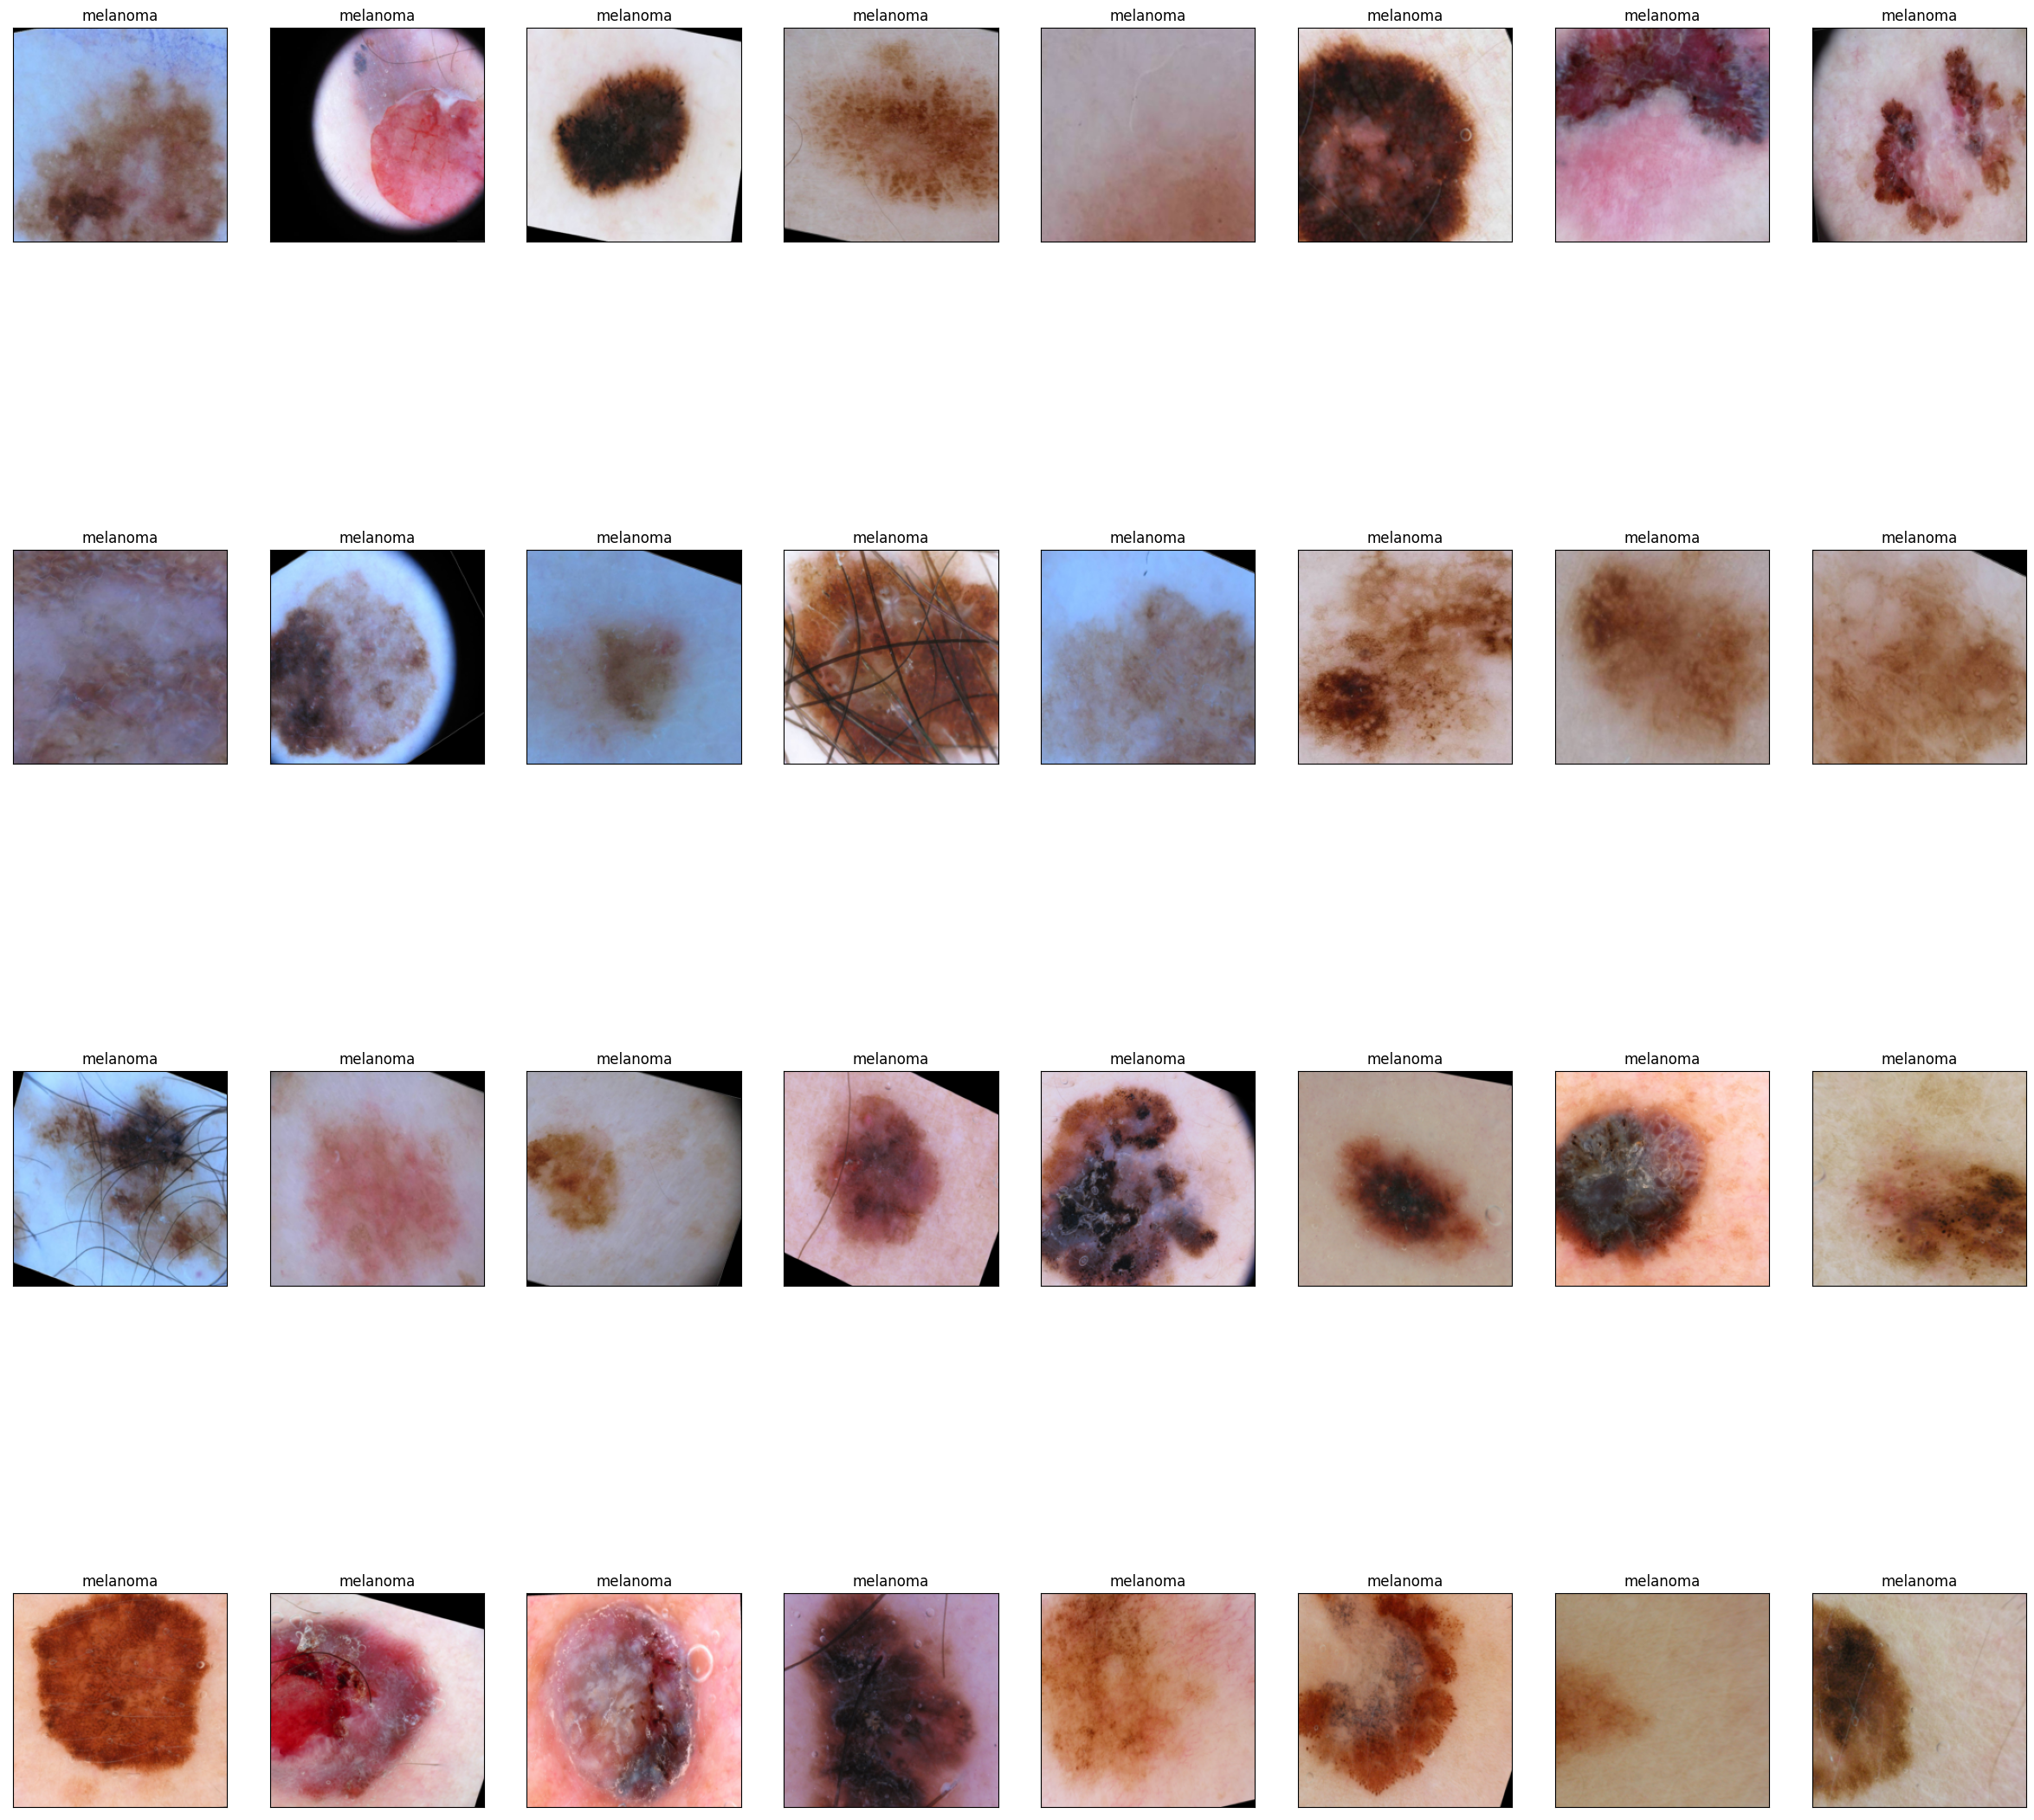

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline


classes = train_data.classes 

def imshow(img):
    img = img / 2 + 0.5  
    plt.imshow(np.transpose(img, (1, 2, 0)))  


images, labels = next(iter(train_loader))
images = images.numpy()


fig = plt.figure(figsize=(30, 30))
for idx, image in enumerate(images):
    ax = fig.add_subplot(4, 8, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]],wrap=True)

In [3]:
use_cuda = torch.cuda.is_available()

## 2 - Specify Loss Function and Optimizer

In [6]:
from torch import nn

criterion = nn.NLLLoss()


def get_optimizer(model):
    optimizer = torch.optim.Adam(model.fc.parameters(), lr = 0.001 )
    return optimizer


## 3 - Model Architecture

In [6]:
from torchvision import models

dir(models)
model = models.resnet50(weights='ResNet50_Weights.DEFAULT')
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(nn.Linear(2048,32),
                                  nn.ReLU(),
                                  nn.Dropout(0.5),
                                  nn.Linear(32,3),
                                  nn.LogSoftmax(dim=1))

print(model)

if use_cuda:
    model = model.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## 4 - Implemeting the Training Algorithm

In [13]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    
    valid_loss_min = np.inf
    
    for epoch in range(1, n_epochs+1):
        
        train_loss = 0.0
        valid_loss = 0.0
        
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
        
            if use_cuda:
                data, target = data.cuda(), target.cuda() 

            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output,target)
            loss.backward()
            optimizer.step()
            
            ## record the average training loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            
            
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            
            if use_cuda:
                data, target = data.cuda(), target.cuda()    

            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output,target)
            ## record the average validation loss
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))
            
            

        # print training/validation losses
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        # saving the best valid loss
        if valid_loss <= valid_loss_min:
            print('Validation decreased from ({:.6f} to {:.6f}) Saving the model.'.format(valid_loss_min,valid_loss))
            torch.save(model.state_dict(), save_path )
            valid_loss_min = valid_loss
        
        
    return model

In [14]:
train(20, data_loaders, model, get_optimizer(model),
                      criterion, use_cuda, 'model.pt')



# load the model that with the best validation accuracy
model.load_state_dict(torch.load('model.pt'))

Epoch: 1 	Training Loss: 1.610426 	Validation Loss: 1.229258
Validation decreased from (inf to 1.229258) Saving the model.
Epoch: 2 	Training Loss: 1.075771 	Validation Loss: 1.092129
Validation decreased from (1.229258 to 1.092129) Saving the model.
Epoch: 3 	Training Loss: 1.036001 	Validation Loss: 1.065435
Validation decreased from (1.092129 to 1.065435) Saving the model.
Epoch: 4 	Training Loss: 1.026489 	Validation Loss: 1.058618
Validation decreased from (1.065435 to 1.058618) Saving the model.
Epoch: 5 	Training Loss: 1.011829 	Validation Loss: 1.066178
Epoch: 6 	Training Loss: 1.016233 	Validation Loss: 1.064757
Epoch: 7 	Training Loss: 1.017683 	Validation Loss: 1.050346
Validation decreased from (1.058618 to 1.050346) Saving the model.
Epoch: 8 	Training Loss: 0.985856 	Validation Loss: 1.066207
Epoch: 9 	Training Loss: 0.984384 	Validation Loss: 1.066758
Epoch: 10 	Training Loss: 0.991097 	Validation Loss: 1.052423
Epoch: 11 	Training Loss: 0.976128 	Validation Loss: 1.0591

<All keys matched successfully>

## 5 - Implementint the Testing Algorithm

In [8]:
def test(loaders, model, criterion, use_cuda):

    
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))



In [9]:
# load the model that with the best validation accuracy
model.load_state_dict(torch.load('model.pt'))

test(data_loaders, model, criterion, use_cuda)

Test Loss: 0.908271


Test Accuracy: 65% (393/600)


## 6 - Skin Cancer Detecting Algorithm

In [10]:
import cv2
from PIL import Image


def Detector(img_path, k):
    
    img = Image.open(img_path)
    transform = transforms.Compose([transforms.Resize(224),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.5,0.5,0.5],
                                                        [0.5,0.5,0.5])])
    imgT = transform(img)
    imageB = torch.unsqueeze(imgT,0)
    model.eval()
    if use_cuda:
        imageB = imageB.cuda()
    with torch.no_grad():
        output = model(imageB)
    _, index = torch.topk(output.squeeze(0),k)
    
    classes_M = [x[0:].replace('_',' ') for x in classes]
    return [classes_M[i] for i in index]

In [11]:
def Skin_Disease_Detector(img_path):

    Skin_Detector = Detector(img_path, 1)
    
    
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()
    print ('The Skin Disease here is ... "{}"'.format(Skin_Detector[0]))

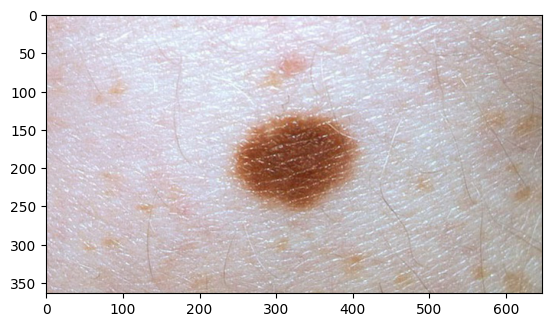

The Skin Disease here is ... "nevus"


In [12]:
Skin_Disease_Detector('pics/6.jpg')